# Data Linkage , And Linkage Key Generation

Please run [Record-Linkage-Example.ipynb](Record-Linkage-Example.ipynb) before this one in order to get the trained model and data.

## Dataset

In [40]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets


import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from transformers import BertTokenizer, BertModel
import torch
from itertools import combinations

[nltk_data] Downloading package punkt to /home/japan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/japan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/japan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
# Load data
df = pd.read_csv("/home/japan/AMIT KUMAR/DC/Data/RRUFF_Export_20230608_052338.csv", encoding='latin-1')

# Select relevant columns from the dataframe
df1 = df[['Mineral Name', 'Chemistry Elements', 'Year First Published']]
df2 = df[['RRUFF Chemistry (plain)', 'RRUFF IDs', 'Country of Type Locality']]
df3 = df[['IMA Chemistry (plain)', 'IMA Number']]
df4 = df[['Structural Groupname', 'Crystal Systems', 'IMA Status']]
df5 = df[['Status Notes', 'Fleischers Groupname', 'Space Groups']]
df6 = df[['Oldest Known Age (Ma)', 'Valence Elements', 'Paragenetic Modes']]

## Loading Test Data

In [47]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import itertools
from scipy import sparse

# Load data
df = pd.read_csv("/home/japan/AMIT KUMAR/DC/Data/RRUFF_Export_20230608_052338.csv", encoding='latin-1')

# Select relevant columns from the dataframe
df1 = df[['Mineral Name', 'Chemistry Elements', 'Year First Published']]
df2 = df[['RRUFF Chemistry (plain)', 'RRUFF IDs', 'Country of Type Locality']]
df3 = df[['IMA Chemistry (plain)', 'IMA Number']]
df4 = df[['Structural Groupname', 'Crystal Systems', 'IMA Status']]
df5 = df[['Status Notes', 'Fleischers Groupname', 'Space Groups']]
df6 = df[['Oldest Known Age (Ma)', 'Valence Elements', 'Paragenetic Modes']]

# Function to preprocess data frames and concatenate column data
def preprocess_dataframes(data_frames):
    concatenated_texts = []
    for df in data_frames:
        for col_name, col_data in df.items():
            if col_name != 'ID':  # Skip 'ID' column
                concatenated_texts.append(' '.join(col_data.astype(str)))
    return concatenated_texts

# Function to generate linkage keys using NLP and clustering
def generate_linkage_keys(data_frames):
    # Step 1: Preprocess data frames and concatenate column data
    concatenated_texts = preprocess_dataframes(data_frames)
    
    # Step 2: Use BERT-based tokenizer and model for embeddings
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    # Tokenize and encode concatenated texts
    tokenized_texts = tokenizer(concatenated_texts, return_tensors='pt', padding=True, truncation=True)
    
    # Step 3: Generate embeddings using BERT model
    with torch.no_grad():
        outputs = model(**tokenized_texts)
        pooler_output = outputs.pooler_output  # Use pooler output for sentence embeddings
    
    # Ensure embeddings size matches expected number of texts
    num_texts = len(concatenated_texts)
    embedding_dim = pooler_output.shape[-1]
    
    if pooler_output.size()[0] != num_texts:
        raise ValueError(f"Expected embeddings size of {num_texts} but got {pooler_output.size()[0]}.")
    
    embeddings = pooler_output.numpy()  # Convert embeddings to numpy array
    
    # Step 4: Compute pairwise cosine similarity between embeddings
    pairwise_similarities = cosine_similarity(embeddings)
    
    # Step 5: Cluster texts based on cosine similarity
    clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='average', distance_threshold=0.5, compute_full_tree=True)
    clusters = clustering.fit_predict(pairwise_similarities)
    
    # Pad clusters if necessary to match the number of columns
    total_columns = sum(len(df.columns) - 1 for df in data_frames)
    if len(clusters) < total_columns:
        clusters = np.concatenate([clusters, np.zeros(total_columns - len(clusters), dtype=int)])
    
    # Step 6: Assign linkage keys based on cluster assignments
    linkage_keys = {}
    idx = 0
    for df_idx, df in enumerate(data_frames):
        for col_name in df.columns:
            if col_name != 'ID':  # Skip 'ID' column
                if idx < len(clusters):
                    key = clusters[idx] + 1  # Assigning cluster ID + 1 as linkage key
                    linkage_keys[(df_idx, col_name)] = key
                    idx += 1
                else:
                    break  # Ensure we do not exceed clusters length
    
    return linkage_keys

# Function to calculate importance score using simple ratio
def calculate_importance_score(linkage_keys):
    # Create a mapping from linkage keys to indices
    key_to_index = {key: idx for idx, key in enumerate(sorted(set(linkage_keys.values())))}
    
    # Generate all combinations of linkage key pairs
    importance_scores = {}
    keys_list = list(linkage_keys.items())
    
    for ((df_idx1, col_name1), key1), ((df_idx2, col_name2), key2) in itertools.permutations(keys_list, 2):
        if df_idx1 != df_idx2:  # Only consider different data frames
            if key1 <= key2:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key1 / key2
            else:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key2 / key1
    
    return importance_scores

# Example usage with 5 dataframes
data_frames = [df1, df2, df3, df4, df5]
linkage_keys = generate_linkage_keys(data_frames)

# Print the generated linkage keys
if linkage_keys:
    
    # Calculate importance scores
    importance_scores = calculate_importance_score(linkage_keys)
    
    print("\nImportance Scores:")
    for combination, score in importance_scores.items():
        print(f"{combination}: Importance Score {score:.4f}")
else:
    print("No linkage keys generated.")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Importance Scores:
((0, 'Mineral Name'), (1, 'RRUFF Chemistry (plain)')): Importance Score 0.7273
((0, 'Mineral Name'), (1, 'RRUFF IDs')): Importance Score 0.8182
((0, 'Mineral Name'), (1, 'Country of Type Locality')): Importance Score 0.9167
((0, 'Mineral Name'), (2, 'IMA Chemistry (plain)')): Importance Score 0.8462
((0, 'Mineral Name'), (2, 'IMA Number')): Importance Score 0.0909
((0, 'Mineral Name'), (3, 'Structural Groupname')): Importance Score 0.5455
((0, 'Mineral Name'), (3, 'Crystal Systems')): Importance Score 0.2727
((0, 'Mineral Name'), (3, 'IMA Status')): Importance Score 0.9091
((0, 'Mineral Name'), (4, 'Status Notes')): Importance Score 0.3636
((0, 'Mineral Name'), (4, 'Fleischers Groupname')): Importance Score 0.4545
((0, 'Mineral Name'), (4, 'Space Groups')): Importance Score 0.1818
((0, 'Chemistry Elements'), (1, 'RRUFF Chemistry (plain)')): Importance Score 0.8750
((0, 'Chemistry Elements'), (1, 'RRUFF IDs')): Importance Score 0.7778
((0, 'Chemistry Elements'), (1, 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and wil


Importance Scores:
((0, 'Mineral Name'), (0, 'Chemistry Elements')): Importance Score 1.0000
((0, 'Mineral Name'), (0, 'Year First Published')): Importance Score 1.0000
((0, 'Mineral Name'), (1, 'RRUFF Chemistry (plain)')): Importance Score 0.7273
((0, 'Mineral Name'), (1, 'RRUFF IDs')): Importance Score 0.8182
((0, 'Mineral Name'), (1, 'Country of Type Locality')): Importance Score 0.9167
((0, 'Mineral Name'), (2, 'IMA Chemistry (plain)')): Importance Score 0.8462
((0, 'Mineral Name'), (2, 'IMA Number')): Importance Score 0.0909
((0, 'Mineral Name'), (3, 'Structural Groupname')): Importance Score 0.5455
((0, 'Mineral Name'), (3, 'Crystal Systems')): Importance Score 0.2727
((0, 'Mineral Name'), (3, 'IMA Status')): Importance Score 0.9091
((0, 'Mineral Name'), (4, 'Status Notes')): Importance Score 0.3636
((0, 'Mineral Name'), (4, 'Fleischers Groupname')): Importance Score 0.4545
((0, 'Mineral Name'), (4, 'Space Groups')): Importance Score 0.1818
((0, 'Chemistry Elements'), (0, 'Miner

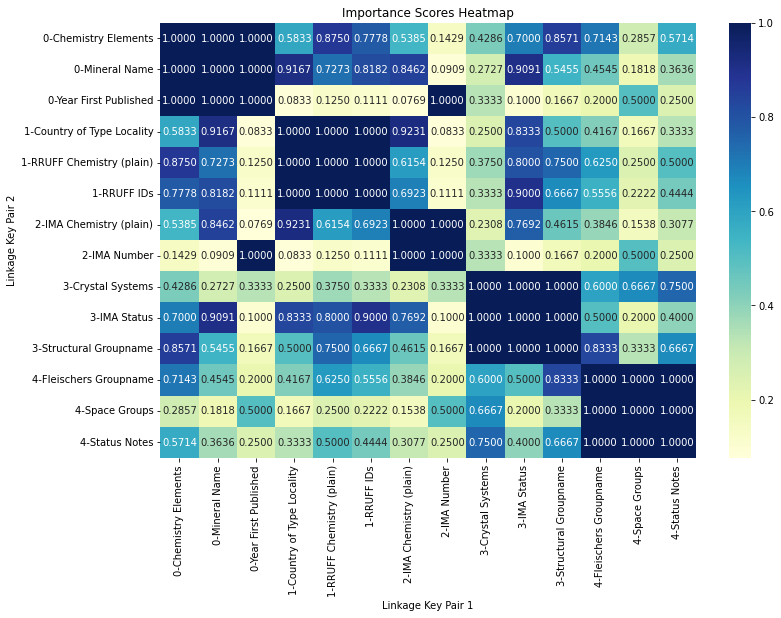

In [51]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_importance_score(linkage_keys):
    # Create a mapping from linkage keys to indices
    key_to_index = {key: idx for idx, key in enumerate(sorted(set(linkage_keys.values())))}
    
    # Generate all combinations of linkage key pairs
    importance_scores = {}
    keys_list = list(linkage_keys.items())
    
    for ((df_idx1, col_name1), key1), ((df_idx2, col_name2), key2) in itertools.permutations(keys_list, 2):
        if df_idx1 != df_idx2:  # Only consider different data frames
            if key1 < key2:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key1 / key2
            else:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key2 / key1
        else:  # Set same DataFrame column pairs to 1
            importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = 1
    
    return importance_scores

def plot_importance_scores(importance_scores):
    # Create a DataFrame from the importance scores dictionary
    df = pd.DataFrame(list(importance_scores.items()), columns=['Combination', 'Importance Score'])
    
    # Split the Combination column into separate columns
    df[['DF1_Col1', 'DF2_Col2']] = pd.DataFrame(df['Combination'].tolist(), index=df.index)
    df[['DF1', 'Column1']] = pd.DataFrame(df['DF1_Col1'].tolist(), index=df.index)
    df[['DF2', 'Column2']] = pd.DataFrame(df['DF2_Col2'].tolist(), index=df.index)
    
    # Drop the intermediate columns
    df.drop(columns=['Combination', 'DF1_Col1', 'DF2_Col2'], inplace=True)
    
    # Create a pivot table for the heatmap
    pivot_df = df.pivot_table(index=['DF1', 'Column1'], columns=['DF2', 'Column2'], values='Importance Score', fill_value=0)
    
    # Set all zero values to 1
    pivot_df.replace(0, 1, inplace=True)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title("Importance Scores Heatmap")
    plt.xlabel("Linkage Key Pair 1")
    plt.ylabel("Linkage Key Pair 2")
    plt.show()

# Example usage with 5 dataframes
# Assuming you have a function `generate_linkage_keys` that returns linkage keys
data_frames = [df1, df2, df3, df4, df5]
linkage_keys = generate_linkage_keys(data_frames)

# Print the generated linkage keys
# Print the generated linkage keys
if linkage_keys:
    # Calculate importance scores
    importance_scores = calculate_importance_score(linkage_keys)
    
    print("\nImportance Scores:")
    for combination, score in importance_scores.items():
        print(f"{combination}: Importance Score {score:.4f}")
    
    # Plot the importance scores
    plot_importance_scores(importance_scores)
else:
    print("No linkage keys generated.")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and wil


Importance Scores:
((0, 'Mineral Name'), (0, 'Chemistry Elements')): Importance Score 1.0000
((0, 'Mineral Name'), (0, 'Year First Published')): Importance Score 1.0000
((0, 'Mineral Name'), (1, 'RRUFF Chemistry (plain)')): Importance Score 0.7273
((0, 'Mineral Name'), (1, 'RRUFF IDs')): Importance Score 0.8182
((0, 'Mineral Name'), (1, 'Country of Type Locality')): Importance Score 0.9167
((0, 'Mineral Name'), (2, 'IMA Chemistry (plain)')): Importance Score 0.8462
((0, 'Mineral Name'), (2, 'IMA Number')): Importance Score 0.0909
((0, 'Mineral Name'), (3, 'Structural Groupname')): Importance Score 0.5455
((0, 'Mineral Name'), (3, 'Crystal Systems')): Importance Score 0.2727
((0, 'Mineral Name'), (3, 'IMA Status')): Importance Score 0.9091
((0, 'Mineral Name'), (4, 'Status Notes')): Importance Score 0.3636
((0, 'Mineral Name'), (4, 'Fleischers Groupname')): Importance Score 0.4545
((0, 'Mineral Name'), (4, 'Space Groups')): Importance Score 0.1818
((0, 'Chemistry Elements'), (0, 'Miner

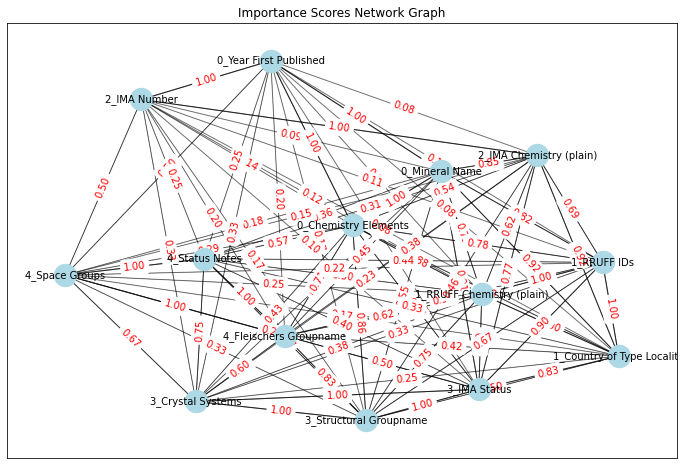

In [52]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

def calculate_importance_score(linkage_keys):
    # Create a mapping from linkage keys to indices
    key_to_index = {key: idx for idx, key in enumerate(sorted(set(linkage_keys.values())))}
    
    # Generate all combinations of linkage key pairs
    importance_scores = {}
    keys_list = list(linkage_keys.items())
    
    for ((df_idx1, col_name1), key1), ((df_idx2, col_name2), key2) in itertools.permutations(keys_list, 2):
        if df_idx1 != df_idx2:  # Only consider different data frames
            if key1 < key2:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key1 / key2
            else:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key2 / key1
        else:  # Set same DataFrame column pairs to 1
            importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = 1
    
    return importance_scores

def plot_importance_scores_network(importance_scores):
    # Create a graph
    G = nx.Graph()
    
    # Add edges to the graph
    for (node1, node2), score in importance_scores.items():
        df1, col1 = node1
        df2, col2 = node2
        G.add_edge(f"{df1}_{col1}", f"{df2}_{col2}", weight=score)
    
    # Draw the graph
    pos = nx.spring_layout(G)  # Positions for all nodes
    edge_weights = nx.get_edge_attributes(G, 'weight')
    
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_edges(G, pos, width=[d['weight'] for (_, _, d) in G.edges(data=True)], alpha=0.75)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
    
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("Importance Scores Network Graph")
    plt.show()

# Example usage with 5 dataframes
# Assuming you have a function `generate_linkage_keys` that returns linkage keys
data_frames = [df1, df2, df3, df4, df5]
linkage_keys = generate_linkage_keys(data_frames)

# Print the generated linkage keys
if linkage_keys:
    # Calculate importance scores
    importance_scores = calculate_importance_score(linkage_keys)
    
    print("\nImportance Scores:")
    for combination, score in importance_scores.items():
        print(f"{combination}: Importance Score {score:.4f}")
    
    # Plot the importance scores
    plot_importance_scores_network(importance_scores)
else:
    print("No linkage keys generated.")


In [53]:
import itertools
import pandas as pd
import holoviews as hv
import hvplot.pandas
from holoviews import opts

hv.extension('bokeh')

def calculate_importance_score(linkage_keys):
    # Create a mapping from linkage keys to indices
    key_to_index = {key: idx for idx, key in enumerate(sorted(set(linkage_keys.values())))}
    
    # Generate all combinations of linkage key pairs
    importance_scores = {}
    keys_list = list(linkage_keys.items())
    
    for ((df_idx1, col_name1), key1), ((df_idx2, col_name2), key2) in itertools.permutations(keys_list, 2):
        if df_idx1 != df_idx2:  # Only consider different data frames
            if key1 < key2:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key1 / key2
            else:
                importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = key2 / key1
        else:  # Set same DataFrame column pairs to 1
            importance_scores[((df_idx1, col_name1), (df_idx2, col_name2))] = 1
    
    return importance_scores

def plot_importance_scores_chord(importance_scores):
    # Prepare data for the chord diagram
    links = []
    for (node1, node2), score in importance_scores.items():
        df1, col1 = node1
        df2, col2 = node2
        links.append({'source': f"{df1}_{col1}", 'target': f"{df2}_{col2}", 'value': score})
    
    links_df = pd.DataFrame(links)
    
    # Create the chord diagram
    chord = hv.Chord(links_df).opts(
        opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color='source', labels='source', node_color='index', edge_line_width=hv.dim('value')*2, width=800, height=800)
    )
    
    hvplot.show(chord)

# Example usage with 5 dataframes
# Assuming you have a function `generate_linkage_keys` that returns linkage keys
data_frames = [df1, df2, df3, df4, df5]
linkage_keys = generate_linkage_keys(data_frames)

# Print the generated linkage keys
if linkage_keys:
    # Calculate importance scores
    importance_scores = calculate_importance_score(linkage_keys)
    
    print("\nImportance Scores:")
    for combination, score in importance_scores.items():
        print(f"{combination}: Importance Score {score:.4f}")
    
    # Plot the importance scores
    plot_importance_scores_chord(importance_scores)
else:
    print("No linkage keys generated.")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ValueError: ClassSelector parameter None value must be an instance of (function, tuple), not <function size at 0x7fb9d2736cf0>.

In [ ]:
import pandas as pd
import numpy as np

In [8]:
print("DataFrame 1:\n", df1)
print("DataFrame 2:\n", df2)
print("DataFrame 3:\n", df3)
print("DataFrame 4:\n", df4)
print("DataFrame 5:\n", df5)
print("DataFrame 6:\n", df6)

DataFrame 1:
           Mineral Name  Chemistry Elements  Year First Published
0            Abellaite         Na Pb C O H                  2014
1           Abelsonite            Ni C H N                  1975
2      Abenakiite-(Ce)    Na Ce Si O P C S                  1991
3         Abernathyite          K U O As H                  1956
4             Abhurite           Sn O H Cl                  1983
...                ...                 ...                   ...
5899  ZvÄstovite-(Zn)          Ag Zn As S                  2020
5900        Zvyaginite  Na Zn Ti Nb Si O H                  2013
5901    Zvyagintsevite               Pd Pb                  1966
5902        Zwieselite            Fe P O F                  1841
5903          ZÃ½kaite         Fe As O S H                  1976

[5904 rows x 3 columns]
DataFrame 2:
                      RRUFF Chemistry (plain) RRUFF IDs  \
0                          NaPb2+2(CO3)2(OH)       NaN   
1                               Ni2+C31H32N4   R070

In [9]:
import torch
from transformers import BertTokenizer, BertModel

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    text = str(text)  # Ensure the input is a string
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=10)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Apply BERT embeddings to relevant columns
df1['Chemistry_Embedding'] = df1['Chemistry Elements'].apply(lambda x: get_bert_embeddings(x))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_3312352/2883193674.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [10]:
print("Processed DataFrame 1:\n", df1)

Processed DataFrame 1:
           Mineral Name  Chemistry Elements  Year First Published  \
0            Abellaite         Na Pb C O H                  2014   
1           Abelsonite            Ni C H N                  1975   
2      Abenakiite-(Ce)    Na Ce Si O P C S                  1991   
3         Abernathyite          K U O As H                  1956   
4             Abhurite           Sn O H Cl                  1983   
...                ...                 ...                   ...   
5899  ZvÄstovite-(Zn)          Ag Zn As S                  2020   
5900        Zvyaginite  Na Zn Ti Nb Si O H                  2013   
5901    Zvyagintsevite               Pd Pb                  1966   
5902        Zwieselite            Fe P O F                  1841   
5903          ZÃ½kaite         Fe As O S H                  1976   

                                    Chemistry_Embedding  
0     [[0.06858743, 0.53518033, 0.2540419, -0.470877...  
1     [[0.25207323, 0.39928243, 0.12741165,

In [11]:
df2['RRUFF_Chemistry_Embedding'] = df2['RRUFF Chemistry (plain)'].apply(lambda x: get_bert_embeddings(x))

/tmp/ipykernel_3312352/3597767108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['RRUFF_Chemistry_Embedding'] = df2['RRUFF Chemistry (plain)'].apply(lambda x: get_bert_embeddings(x))


In [12]:
df3['IMA_Chemistry_Embedding'] = df3['IMA Chemistry (plain)'].apply(lambda x: get_bert_embeddings(x))

/tmp/ipykernel_3312352/3358832132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['IMA_Chemistry_Embedding'] = df3['IMA Chemistry (plain)'].apply(lambda x: get_bert_embeddings(x))


In [13]:
df4['Structural_Groupname_Embedding'] = df4['Structural Groupname'].apply(lambda x: get_bert_embeddings(x))

/tmp/ipykernel_3312352/1235262031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Structural_Groupname_Embedding'] = df4['Structural Groupname'].apply(lambda x: get_bert_embeddings(x))


In [14]:
df5['Status_Notes_Embedding'] = df5['Status Notes'].apply(lambda x: get_bert_embeddings(x))

/tmp/ipykernel_3312352/2417259427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['Status_Notes_Embedding'] = df5['Status Notes'].apply(lambda x: get_bert_embeddings(x))


In [15]:
df6['Valence_Elements_Embedding'] = df6['Valence Elements'].apply(lambda x: get_bert_embeddings(x))

/tmp/ipykernel_3312352/1110925404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df6['Valence_Elements_Embedding'] = df6['Valence Elements'].apply(lambda x: get_bert_embeddings(x))


In [16]:
print("Processed DataFrame 2:\n", df2)
print("Processed DataFrame 3:\n", df3)
print("Processed DataFrame 4:\n", df4)
print("Processed DataFrame 5:\n", df5)
print("Processed DataFrame 6:\n", df6)

Processed DataFrame 2:
                      RRUFF Chemistry (plain) RRUFF IDs  \
0                          NaPb2+2(CO3)2(OH)       NaN   
1                               Ni2+C31H32N4   R070007   
2     Na26Ce3+6(SiO3)6(PO4)6(C4+O3)6(S4+O2)O       NaN   
3                       K(U6+O2)As5+O4Â·3H2O       NaN   
4                         Sn2+21O6(OH)14Cl16   R060227   
...                                      ...       ...   
5899             Ag1+6(Ag1+4Zn2+2)As3+4S2-13       NaN   
5900   Na2Zn2+Ti4+Nb5+2(Si2O7)2O2(OH)2(H2O)4       NaN   
5901                                   Pd3Pb       NaN   
5902                               Fe2+2PO4F   R050279   
5903          Fe3+4(As5+O4)3S6+O4(OH)Â·15H2O   R070477   

     Country of Type Locality  \
0                       Spain   
1                         USA   
2                      Canada   
3                         USA   
4                Saudi Arabia   
...                       ...   
5899           Czech Republic   
5900           

In [39]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler1 = StandardScaler()
scaler6 = StandardScaler()

year_features = scaler1.fit_transform(df1[['Year First Published']])
age_features = scaler6.fit_transform(df6[['Oldest Known Age (Ma)']])

# Combine features into a hybrid feature space
chemistry_embeddings1 = np.vstack(df1['Chemistry_Embedding'].values)
chemistry_embeddings2 = np.vstack(df2['RRUFF_Chemistry_Embedding'].values)
chemistry_embeddings3 = np.vstack(df3['IMA_Chemistry_Embedding'].values)
groupname_embeddings4 = np.vstack(df4['Structural_Groupname_Embedding'].values)
notes_embeddings5 = np.vstack(df5['Status_Notes_Embedding'].values)
elements_embeddings6 = np.vstack(df6['Valence_Elements_Embedding'].values)

hybrid_features1 = np.hstack([chemistry_embeddings1, year_features])
hybrid_features2 = np.hstack([chemistry_embeddings2])
hybrid_features3 = np.hstack([chemistry_embeddings3])
hybrid_features4 = np.hstack([groupname_embeddings4])
hybrid_features5 = np.hstack([notes_embeddings5])
hybrid_features6 = np.hstack([elements_embeddings6, age_features])

print("Hybrid Features 1 Shape:", hybrid_features1.shape)
print("Hybrid Features 2 Shape:", hybrid_features2.shape)
print("Hybrid Features 3 Shape:", hybrid_features3.shape)
print("Hybrid Features 4 Shape:", hybrid_features4.shape)
print("Hybrid Features 5 Shape:", hybrid_features5.shape)
print("Hybrid Features 6 Shape:", hybrid_features6.shape)

KeyError: 'Chemistry_Embedding'

In [21]:
'''import torch.nn as nn
import torch.optim as optim

class LinkageKeyModel(nn.Module):
    def __init__(self, input_dim):
        super(LinkageKeyModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize models
input_dim1 = hybrid_features1.shape[1] + hybrid_features2.shape[1]
input_dim2 = hybrid_features3.shape[1] + hybrid_features4.shape[1]
input_dim3 = hybrid_features5.shape[1] + hybrid_features6.shape[1]

model1 = LinkageKeyModel(input_dim1)
model2 = LinkageKeyModel(input_dim2)
model3 = LinkageKeyModel(input_dim3)

def generate_linkage_keys(hybrid_features_a, hybrid_features_b, model, batch_size=64):
    # Initialize the similarity matrix
    similarity_matrix = np.zeros((hybrid_features_a.shape[0], hybrid_features_b.shape[0]))

    for i in range(0, hybrid_features_a.shape[0], batch_size):
        for j in range(0, hybrid_features_b.shape[0], batch_size):
            # Combine features for each batch
            batch_a = hybrid_features_a[i:i+batch_size]
            batch_b = hybrid_features_b[j:j+batch_size]
            
            combined_features = np.array([np.hstack([a, b]) for a in batch_a for b in batch_b])
            
            # Convert to tensor
            combined_features_tensor = torch.tensor(combined_features, dtype=torch.float32)
            
            # Predict linkage scores
            with torch.no_grad():
                linkage_scores = model(combined_features_tensor).numpy()
            
            # Reshape and update the similarity matrix
            linkage_scores = linkage_scores.reshape(batch_a.shape[0], batch_b.shape[0])
            similarity_matrix[i:i+batch_a.shape[0], j:j+batch_b.shape[0]] = linkage_scores
    
    return similarity_matrix

# User specifies criteria (simulated for demonstration purposes)
user_criteria = 'Chemistry and Age'

# Generate linkage keys for different pairs of data frames
linkage_keys1 = generate_linkage_keys(hybrid_features1, hybrid_features2, model1)
linkage_keys2 = generate_linkage_keys(hybrid_features3, hybrid_features4, model2)
linkage_keys3 = generate_linkage_keys(hybrid_features5, hybrid_features6, model3)

# Find the best matches
matched_indices1 = linkage_keys1.argmax(axis=1)
matched_indices2 = linkage_keys2.argmax(axis=1)
matched_indices3 = linkage_keys3.argmax(axis=1)

matches1 = [(df1.iloc[i]['Mineral Name'], df2.iloc[matched_indices1[i]]['Country of Type Locality']) for i in range(len(df1))]
matches2 = [(df3.iloc[i]['IMA Number'], df4.iloc[matched_indices2[i]]['IMA Status']) for i in range(len(df3))]
matches3 = [(df5.iloc[i]['Fleischers Groupname'], df6.iloc[matched_indices3[i]]['Paragenetic Modes']) for i in range(len(df5))]

print("Matches 1 based on user criteria:", matches1)
print("Matches 2 based on user criteria:", matches2)
print("Matches 3 based on user criteria:", matches3)
'''

'import torch.nn as nn\nimport torch.optim as optim\n\nclass LinkageKeyModel(nn.Module):\n    def __init__(self, input_dim):\n        super(LinkageKeyModel, self).__init__()\n        self.fc = nn.Sequential(\n            nn.Linear(input_dim, 128),\n            nn.ReLU(),\n            nn.Linear(128, 64),\n            nn.ReLU(),\n            nn.Linear(64, 1),\n            nn.Sigmoid()\n        )\n    \n    def forward(self, x):\n        return self.fc(x)\n\n# Initialize models\ninput_dim1 = hybrid_features1.shape[1] + hybrid_features2.shape[1]\ninput_dim2 = hybrid_features3.shape[1] + hybrid_features4.shape[1]\ninput_dim3 = hybrid_features5.shape[1] + hybrid_features6.shape[1]\n\nmodel1 = LinkageKeyModel(input_dim1)\nmodel2 = LinkageKeyModel(input_dim2)\nmodel3 = LinkageKeyModel(input_dim3)\n\ndef generate_linkage_keys(hybrid_features_a, hybrid_features_b, model, batch_size=64):\n    # Initialize the similarity matrix\n    similarity_matrix = np.zeros((hybrid_features_a.shape[0], hybrid_

In [22]:
# Assuming user criteria relates to df6 data frame
#best_matches_based_on_user_criteria = matches3  # Based on the criteria 'Chemistry and Age'
#print("Best Matches Based on User Criteria:", best_matches_based_on_user_criteria)

In [27]:
'''import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim

# Load data
df = pd.read_csv("/home/japan/AMIT KUMAR/DC/Data/RRUFF_Export_20230608_052338.csv", encoding='latin-1')

# Select relevant columns from the dataframe
df1 = df[['Mineral Name', 'Chemistry Elements', 'Year First Published']]
df2 = df[['RRUFF Chemistry (plain)', 'RRUFF IDs', 'Country of Type Locality']]
df3 = df[['IMA Chemistry (plain)', 'IMA Number']]
df4 = df[['Structural Groupname', 'Crystal Systems', 'IMA Status']]
df5 = df[['Status Notes', 'Fleischers Groupname', 'Space Groups']]
df6 = df[['Oldest Known Age (Ma)', 'Valence Elements', 'Paragenetic Modes']]

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    text = str(text)  # Ensure the input is a string
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=10)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Apply BERT embeddings to relevant columns
df1['Chemistry_Embedding'] = df1['Chemistry Elements'].apply(lambda x: get_bert_embeddings(x))
df2['RRUFF_Chemistry_Embedding'] = df2['RRUFF Chemistry (plain)'].apply(lambda x: get_bert_embeddings(x))
df3['IMA_Chemistry_Embedding'] = df3['IMA Chemistry (plain)'].apply(lambda x: get_bert_embeddings(x))
df4['Structural_Groupname_Embedding'] = df4['Structural Groupname'].apply(lambda x: get_bert_embeddings(x))
df5['Status_Notes_Embedding'] = df5['Status Notes'].apply(lambda x: get_bert_embeddings(x))
df6['Valence_Elements_Embedding'] = df6['Valence Elements'].apply(lambda x: get_bert_embeddings(x))

# Standardize numerical features
scaler1 = StandardScaler()
scaler6 = StandardScaler()

year_features = scaler1.fit_transform(df1[['Year First Published']])
age_features = scaler6.fit_transform(df6[['Oldest Known Age (Ma)']])

# Combine features into a hybrid feature space
chemistry_embeddings1 = np.vstack(df1['Chemistry_Embedding'].values)
chemistry_embeddings2 = np.vstack(df2['RRUFF_Chemistry_Embedding'].values)
chemistry_embeddings3 = np.vstack(df3['IMA_Chemistry_Embedding'].values)
groupname_embeddings4 = np.vstack(df4['Structural_Groupname_Embedding'].values)
notes_embeddings5 = np.vstack(df5['Status_Notes_Embedding'].values)
elements_embeddings6 = np.vstack(df6['Valence_Elements_Embedding'].values)

hybrid_features1 = np.hstack([chemistry_embeddings1, year_features])
hybrid_features2 = np.hstack([chemistry_embeddings2])
hybrid_features3 = np.hstack([chemistry_embeddings3])
hybrid_features4 = np.hstack([groupname_embeddings4])
hybrid_features5 = np.hstack([notes_embeddings5])
hybrid_features6 = np.hstack([elements_embeddings6, age_features])

print("Hybrid Features 1 Shape:", hybrid_features1.shape)
print("Hybrid Features 2 Shape:", hybrid_features2.shape)
print("Hybrid Features 3 Shape:", hybrid_features3.shape)
print("Hybrid Features 4 Shape:", hybrid_features4.shape)
print("Hybrid Features 5 Shape:", hybrid_features5.shape)
print("Hybrid Features 6 Shape:", hybrid_features6.shape)'''

'import pandas as pd\nimport numpy as np\nimport torch\nfrom transformers import BertTokenizer, BertModel\nfrom sklearn.preprocessing import StandardScaler\nimport torch.nn as nn\nimport torch.optim as optim\n\n# Load data\ndf = pd.read_csv("/home/japan/AMIT KUMAR/DC/Data/RRUFF_Export_20230608_052338.csv", encoding=\'latin-1\')\n\n# Select relevant columns from the dataframe\ndf1 = df[[\'Mineral Name\', \'Chemistry Elements\', \'Year First Published\']]\ndf2 = df[[\'RRUFF Chemistry (plain)\', \'RRUFF IDs\', \'Country of Type Locality\']]\ndf3 = df[[\'IMA Chemistry (plain)\', \'IMA Number\']]\ndf4 = df[[\'Structural Groupname\', \'Crystal Systems\', \'IMA Status\']]\ndf5 = df[[\'Status Notes\', \'Fleischers Groupname\', \'Space Groups\']]\ndf6 = df[[\'Oldest Known Age (Ma)\', \'Valence Elements\', \'Paragenetic Modes\']]\n\n# Load BERT model and tokenizer\ntokenizer = BertTokenizer.from_pretrained(\'bert-base-uncased\')\nmodel = BertModel.from_pretrained(\'bert-base-uncased\')\n\ndef ge

In [26]:
"""class LinkageKeyModel(nn.Module):
    def __init__(self, input_dim):
        super(LinkageKeyModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc(x)

# Initialize models
input_dim1 = hybrid_features1.shape[1] + hybrid_features2.shape[1]
input_dim2 = hybrid_features3.shape[1] + hybrid_features4.shape[1]
input_dim3 = hybrid_features5.shape[1] + hybrid_features6.shape[1]

model1 = LinkageKeyModel(input_dim1)
model2 = LinkageKeyModel(input_dim2)
model3 = LinkageKeyModel(input_dim3)

def generate_linkage_keys(hybrid_features_a, hybrid_features_b, model, batch_size=64):
    # Initialize the similarity matrix
    similarity_matrix = np.zeros((hybrid_features_a.shape[0], hybrid_features_b.shape[0]))

    for i in range(0, hybrid_features_a.shape[0], batch_size):
        for j in range(0, hybrid_features_b.shape[0], batch_size):
            # Combine features for each batch
            batch_a = hybrid_features_a[i:i+batch_size]
            batch_b = hybrid_features_b[j:j+batch_size]
            
            combined_features = np.array([np.hstack([a, b]) for a in batch_a for b in batch_b])
            
            # Convert to tensor
            combined_features_tensor = torch.tensor(combined_features, dtype=torch.float32)
            
            # Predict linkage scores
            with torch.no_grad():
                linkage_scores = model(combined_features_tensor).numpy()
            
            # Reshape and update the similarity matrix
            linkage_scores = linkage_scores.reshape(batch_a.shape[0], batch_b.shape[0])
            similarity_matrix[i:i+batch_a.shape[0], j:j+batch_b.shape[0]] = linkage_scores
    
    return similarity_matrix

# User specifies criteria (simulated for demonstration purposes)
user_criteria = df6

# Generate linkage keys for different pairs of data frames
linkage_keys1 = generate_linkage_keys(hybrid_features1, hybrid_features2, model1)
linkage_keys2 = generate_linkage_keys(hybrid_features3, hybrid_features4, model2)
linkage_keys3 = generate_linkage_keys(hybrid_features5, hybrid_features6, model3)

# Find the best matches
matched_indices1 = linkage_keys1.argmax(axis=1)
matched_indices2 = linkage_keys2.argmax(axis=1)
matched_indices3 = linkage_keys3.argmax(axis=1)

matches1 = [(df1.iloc[i]['Mineral Name'], df2.iloc[matched_indices1[i]]['Country of Type Locality']) for i in range(len(df1))]
matches2 = [(df3.iloc[i]['IMA Number'], df4.iloc[matched_indices2[i]]['IMA Status']) for i in range(len(df3))]
matches3 = [(df5.iloc[i]['Fleischers Groupname'], df6.iloc[matched_indices3[i]]['Paragenetic Modes']) for i in range(len(df5))]

print("Matches 1 based on user criteria:", matches1)
print("Matches 2 based on user criteria:", matches2)
print("Matches 3 based on user criteria:", matches3)

# Select the best linkage based on user criteria
best_matches_based_on_user_criteria = matches3  # Based on the criteria 'Chemistry and Age'

print("Best Matches Based on User Criteria:", best_matches_based_on_user_criteria)"""

'class LinkageKeyModel(nn.Module):\n    def __init__(self, input_dim):\n        super(LinkageKeyModel, self).__init__()\n        self.fc = nn.Sequential(\n            nn.Linear(input_dim, 128),\n            nn.ReLU(),\n            nn.Linear(128, 64),\n            nn.ReLU(),\n            nn.Linear(64, 1),\n            nn.Sigmoid()\n        )\n    \n    def forward(self, x):\n        return self.fc(x)\n\n# Initialize models\ninput_dim1 = hybrid_features1.shape[1] + hybrid_features2.shape[1]\ninput_dim2 = hybrid_features3.shape[1] + hybrid_features4.shape[1]\ninput_dim3 = hybrid_features5.shape[1] + hybrid_features6.shape[1]\n\nmodel1 = LinkageKeyModel(input_dim1)\nmodel2 = LinkageKeyModel(input_dim2)\nmodel3 = LinkageKeyModel(input_dim3)\n\ndef generate_linkage_keys(hybrid_features_a, hybrid_features_b, model, batch_size=64):\n    # Initialize the similarity matrix\n    similarity_matrix = np.zeros((hybrid_features_a.shape[0], hybrid_features_b.shape[0]))\n\n    for i in range(0, hybrid_

In [35]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# Load data
df = pd.read_csv("/home/japan/AMIT KUMAR/DC/Data/RRUFF_Export_20230608_052338.csv", encoding='latin-1')

# Select relevant columns from the dataframe
df1 = df[['Mineral Name', 'Chemistry Elements', 'Year First Published']]
df2 = df[['RRUFF Chemistry (plain)', 'RRUFF IDs', 'Country of Type Locality']]
df3 = df[['IMA Chemistry (plain)', 'IMA Number']]
df4 = df[['Structural Groupname', 'Crystal Systems', 'IMA Status']]
df5 = df[['Status Notes', 'Fleischers Groupname', 'Space Groups']]
df6 = df[['Oldest Known Age (Ma)', 'Valence Elements', 'Paragenetic Modes']]

# Load SentenceTransformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def get_embeddings(text):
    text = str(text)  # Ensure the input is a string
    return model.encode(text)

# Apply embeddings to relevant columns
df1['Chemistry_Embedding'] = df1['Chemistry Elements'].apply(lambda x: get_embeddings(x))
df2['RRUFF_Chemistry_Embedding'] = df2['RRUFF Chemistry (plain)'].apply(lambda x: get_embeddings(x))
df3['IMA_Chemistry_Embedding'] = df3['IMA Chemistry (plain)'].apply(lambda x: get_embeddings(x))
df4['Structural_Groupname_Embedding'] = df4['Structural Groupname'].apply(lambda x: get_embeddings(x))
df5['Status_Notes_Embedding'] = df5['Status Notes'].apply(lambda x: get_embeddings(x))
df6['Valence_Elements_Embedding'] = df6['Valence Elements'].apply(lambda x: get_embeddings(x))

# Standardize numerical features
scaler1 = StandardScaler()
scaler6 = StandardScaler()

df1['Year_First_Published_Std'] = scaler1.fit_transform(df1[['Year First Published']])
df6['Oldest_Known_Age_Std'] = scaler6.fit_transform(df6[['Oldest Known Age (Ma)']])

# Create lists of embedding columns to compare
embedding_columns_df1 = ['Chemistry_Embedding']
embedding_columns_df2 = ['RRUFF_Chemistry_Embedding']
embedding_columns_df3 = ['IMA_Chemistry_Embedding']
embedding_columns_df4 = ['Structural_Groupname_Embedding']
embedding_columns_df5 = ['Status_Notes_Embedding']
embedding_columns_df6 = ['Valence_Elements_Embedding']

# Create lists of numerical columns to compare
numerical_columns_df1 = ['Year_First_Published_Std']
numerical_columns_df6 = ['Oldest_Known_Age_Std']

# Create a function to compute the similarity between columns
def compute_similarity(df6_col, df_other_col):
    return cosine_similarity(df6_col, df_other_col).mean()

# Initialize a dictionary to store the best matches
best_matches = {}

# Compare each embedding column in df6 with embedding columns in df1 to df5
for df6_col_name in embedding_columns_df6:
    best_score = 0
    best_match = None
    
    for df1_col_name in embedding_columns_df1:
        score = compute_similarity(np.vstack(df6[df6_col_name]), np.vstack(df1[df1_col_name]))
        if score > best_score:
            best_score = score
            best_match = ('df1', df1_col_name)
    
    for df2_col_name in embedding_columns_df2:
        score = compute_similarity(np.vstack(df6[df6_col_name]), np.vstack(df2[df2_col_name]))
        if score > best_score:
            best_score = score
            best_match = ('df2', df2_col_name)
    
    for df3_col_name in embedding_columns_df3:
        score = compute_similarity(np.vstack(df6[df6_col_name]), np.vstack(df3[df3_col_name]))
        if score > best_score:
            best_score = score
            best_match = ('df3', df3_col_name)
    
    for df4_col_name in embedding_columns_df4:
        score = compute_similarity(np.vstack(df6[df6_col_name]), np.vstack(df4[df4_col_name]))
        if score > best_score:
            best_score = score
            best_match = ('df4', df4_col_name)
    
    for df5_col_name in embedding_columns_df5:
        score = compute_similarity(np.vstack(df6[df6_col_name]), np.vstack(df5[df5_col_name]))
        if score > best_score:
            best_score = score
            best_match = ('df5', df5_col_name)
    
    best_matches[df6_col_name] = best_match

# Compare each numerical column in df6 with numerical columns in df1
for df6_col_name in numerical_columns_df6:
    best_score = 0
    best_match = None
    
    for df1_col_name in numerical_columns_df1:
        score = compute_similarity(df6[[df6_col_name]], df1[[df1_col_name]])
        if score > best_score:
            best_score = score
            best_match = ('df1', df1_col_name)
    
    best_matches[df6_col_name] = best_match

# Print the best matches
print("Best Matches for Each Column in df6:")
for df6_col_name, match in best_matches.items():
    print(f"{df6_col_name} -> {match}")


/tmp/ipykernel_3312352/2366069363.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Chemistry_Embedding'] = df1['Chemistry Elements'].apply(lambda x: get_embeddings(x))
/tmp/ipykernel_3312352/2366069363.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['RRUFF_Chemistry_Embedding'] = df2['RRUFF Chemistry (plain)'].apply(lambda x: get_embeddings(x))
/tmp/ipykernel_3312352/2366069363.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

ValueError: Input contains NaN.